# Setting global seed

In [1]:
import os
import tensorflow as tf
import numpy as np
import random

# Set a seed value
seed_value = 25

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)



# Importing the libraries

In [2]:
# TODO: Import other necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive

drive.mount('/content/drive/')
%cd /content/drive/MyDrive/A3

Mounted at /content/drive/
/content/drive/MyDrive/A3


# Load the dataset

In [3]:
# TODO: Populate the create_image_generators() function
def create_image_generators(train_dir, target_size=(150, 150), batch_size=20, val_split=0.2):
    """
    Create training and validation generators for image data.

    Parameters:
    - base_dir: Path to the base directory where the 'train' folder is located.
    - target_size: Tuple of integers, the dimensions to which all images found will be resized.
    - batch_size: Integer, size of the batches of data.
    - val_split: Float, the fraction of images reserved for validation.

    Returns:
    - train_generator: Training data generator.
    - validation_generator: Validation data generator.
    """

    # TODO: Creating Image Data Generator for both training and validation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=val_split
    )

    # TODO: Create a training data generator
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        seed=25
    )

    # TODO: Create a validation data generator
    validation_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        seed=25
    )

    return train_generator, validation_generator

train_dir = '/content/drive/MyDrive/A3/train/train'
train_generator, validation_generator = create_image_generators(train_dir)

Found 148 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [4]:
def print_generator_info(generator):
    """
    Print information about a data generator.

    Parameters:
    - generator: The data generator (train or validation).
    """
    # Number of images
    num_images = generator.samples
    # Batch size
    batch_size = generator.batch_size
    # Class indices
    class_indices = generator.class_indices
    # Number of classes
    num_classes = generator.num_classes
    # Filenames
    filenames = generator.filenames

    print(f"Number of images: {num_images}")
    print(f"Batch size: {batch_size}")
    print(f"Class indices: {class_indices}")
    print(f"Number of classes: {num_classes}")
    print(f"Number of filenames loaded: {len(filenames)}")  # Number of filenames might be large

# Example usage:
print("Training Generator Info:")
print_generator_info(train_generator)
print("\nValidation Generator Info:")
print_generator_info(validation_generator)


Training Generator Info:
Number of images: 148
Batch size: 20
Class indices: {'not_polar': 0, 'polar': 1}
Number of classes: 2
Number of filenames loaded: 148

Validation Generator Info:
Number of images: 36
Batch size: 20
Class indices: {'not_polar': 0, 'polar': 1}
Number of classes: 2
Number of filenames loaded: 36


# Define the CNN model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dropout (Dropout)           (None, 82944)             0

In [6]:
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

Total number of parameters: 42487745


# Compile and fit the CNN model

In [30]:
# TODO: Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# TODO: Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# Print final accuracy
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final training accuracy: {final_accuracy:.4f}")
print(f"Final validation accuracy: {final_val_accuracy:.4f}")

Epoch 1/20
7/7 [==============================] - 4s 320ms/step - loss: 0.2938 - accuracy: 0.9141 - val_loss: 0.4919 - val_accuracy: 0.8500
Epoch 2/20
7/7 [==============================] - 2s 330ms/step - loss: 0.1233 - accuracy: 0.9571 - val_loss: 0.3581 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 2s 366ms/step - loss: 0.1736 - accuracy: 0.9219 - val_loss: 0.4572 - val_accuracy: 0.8500
Epoch 4/20
7/7 [==============================] - 2s 283ms/step - loss: 0.0999 - accuracy: 0.9453 - val_loss: 0.2834 - val_accuracy: 0.9000
Epoch 5/20
7/7 [==============================] - 2s 282ms/step - loss: 0.1272 - accuracy: 0.9531 - val_loss: 0.3901 - val_accuracy: 0.8500
Epoch 6/20
7/7 [==============================] - 2s 254ms/step - loss: 0.1176 - accuracy: 0.9531 - val_loss: 0.7295 - val_accuracy: 0.8500
Epoch 7/20
7/7 [==============================] - 2s 251ms/step - loss: 0.1414 - accuracy: 0.9429 - val_loss: 0.4145 - val_accuracy: 0.8000
Epoch 8/20
7/7 [====

# Plot Training and Validation accuracies

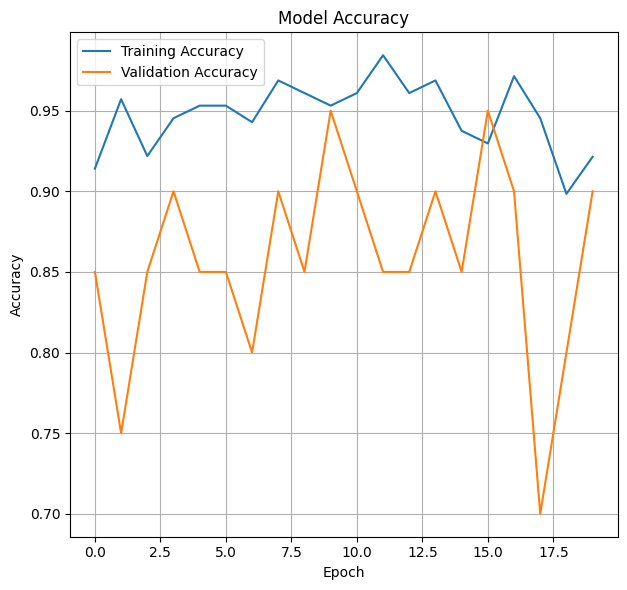

In [31]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Plot Training and Validation losses

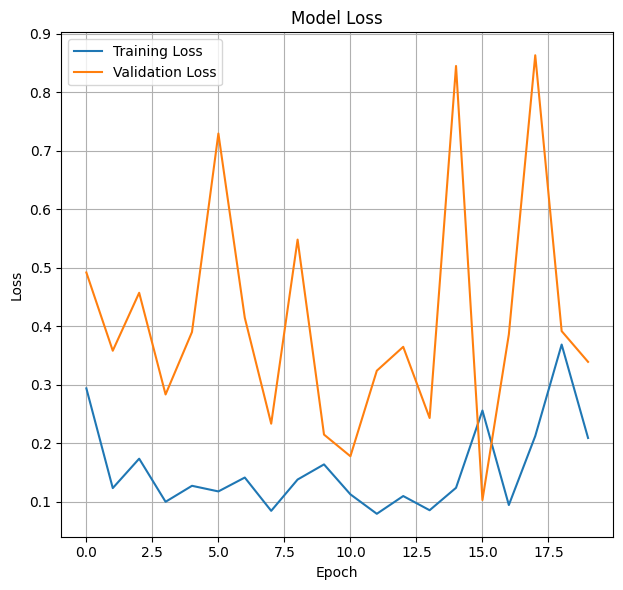

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Testing


In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_display_predict_image(img_path, model, size=(150, 150)):
    """
    Load, preprocess, display, and predict the class of an image using a given model.

    Parameters:
    - img_path: String, path to the image file.
    - model: TensorFlow/Keras model that will be used to predict the image.
    - size: Tuple of integers, target size of the image (height, width).
    """
    # Load an image file to PIL format, target size can be adjusted
    img = Image.open(img_path).resize(size)

    # Convert the PIL image to a numpy array
    img_array = np.array(img)

    # Add a dimension to transform the array into a batch shape
    img_batch = np.expand_dims(img_array, axis=0)

    # Normalize the image pixels to [0, 1]
    img_preprocessed = img_batch.astype('float32') / 255.0

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict using the provided model
    prediction = model.predict(img_preprocessed)

    print(prediction)
    print("Polar Bear" if prediction[0][0] > 0.5 else "Not Polar Bear")

## Inference for test_1.jpg

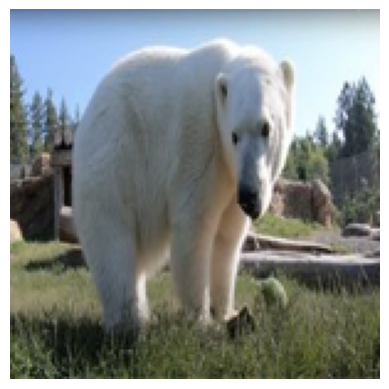

1/1 [==============================] - 0s 263ms/step
[[0.54134846]]
Polar Bear


In [36]:
img_path = '/content/drive/MyDrive/A3/test/test/test_1.jpg'
load_display_predict_image(img_path,model)



## Inference for test_2.jpg

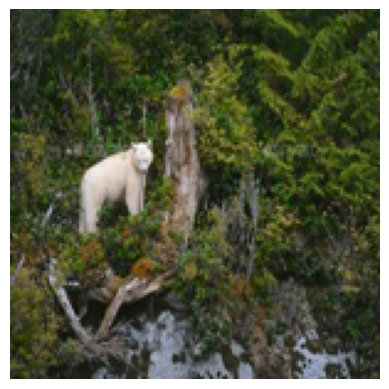

1/1 [==============================] - 0s 24ms/step
[[0.03182023]]
Not Polar Bear


In [37]:
img_path = '/content/drive/MyDrive/A3/test/test/test_2.jpg'
load_display_predict_image(img_path,model)

## Inference for test_3.jpg

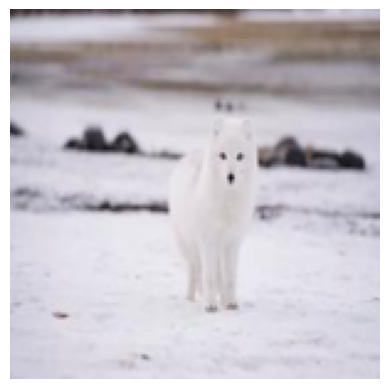

1/1 [==============================] - 0s 32ms/step
[[0.9978696]]
Polar Bear


In [38]:
img_path = '/content/drive/MyDrive/A3/test/test/test_3.jpg'
load_display_predict_image(img_path,model)

## Inference for test_4.jpg

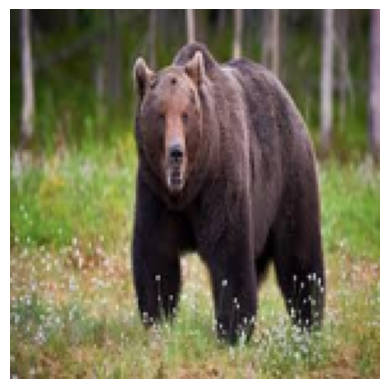

1/1 [==============================] - 0s 19ms/step
[[4.0372208e-05]]
Not Polar Bear


In [39]:
img_path = '/content/drive/MyDrive/A3/test/test/test_4.jpg'
load_display_predict_image(img_path,model)

## Inference for test_5.jpg

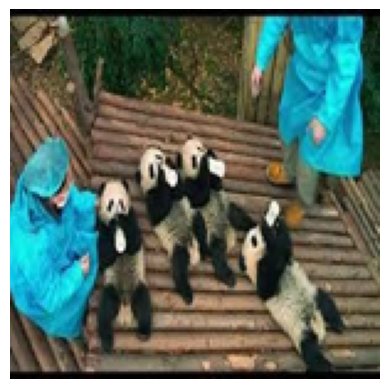

1/1 [==============================] - 0s 25ms/step
[[0.00203967]]
Not Polar Bear


In [40]:
img_path = '/content/drive/MyDrive/A3/test/test/test_5.jpg'
load_display_predict_image(img_path,model)

## Inference for test_6.jpg

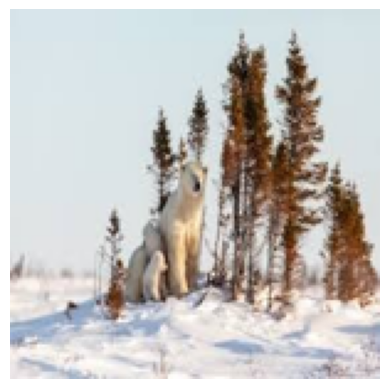

1/1 [==============================] - 0s 19ms/step
[[0.9495855]]
Polar Bear


In [41]:
img_path = '/content/drive/MyDrive/A3/test/test/test_6.jpg'
load_display_predict_image(img_path,model)

# Visualize layer activations

In [42]:
# Load and preprocess an image
def load_image(img_path, size=(150,150)):
    img = image.load_img(img_path, target_size=size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

# Define a function to display the activations
def display_layer_activations(activations, model):
    layer_names = [layer.name for layer in model.layers[:4]]
    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image = np.maximum(channel_image, 0) / max(channel_image.std(), 1e-5)
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

1/1 [==============================] - 0s 53ms/step


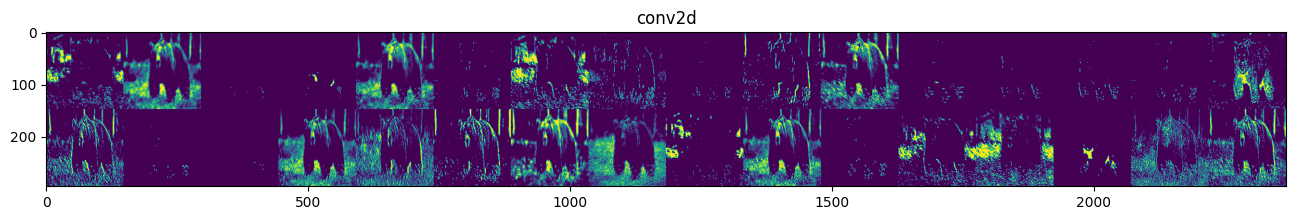

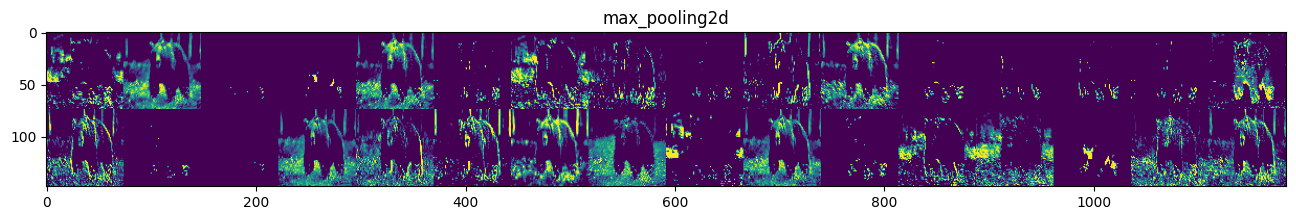

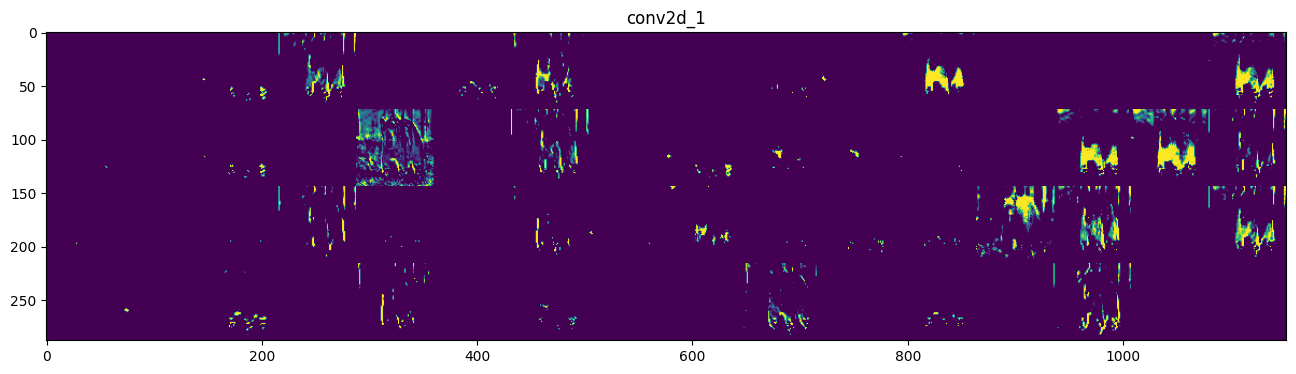

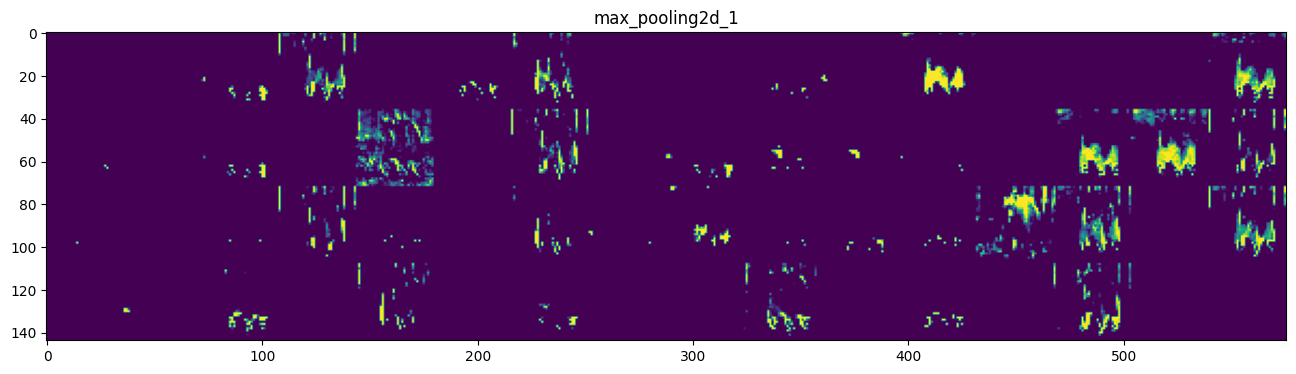

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Model
# TODO: Define a function to create a model that returns output from each layer
def get_layer_outputs(model, img_tensor):
    # Extracts outputs for all layers up to the last MaxPooling layer (index 3)
    layer_outputs = [layer.output for layer in model.layers[:4]]
    # Creates a new model that will return these outputs, given the model input
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Returns a list of numpy arrays, one array per layer activation
    activations = activation_model.predict(img_tensor)

    return activations


# Load and preprocess an image
img_path = '/content/drive/MyDrive/A3/test/test/test_4.jpg'
new_image = load_image(img_path)

# Get activations and display them
activations = get_layer_outputs(model, new_image)
display_layer_activations(activations,model)